### Cutdata (Soetkin)

In [ ]:


# #Extra homemade classes
# from spectralline import Spectralline
# from retrievespectra import Retrievespectra
# from savervs import Savervs
'''
This class is used to find the maxima of emission lines, double-peaked or not, and
return the wavelength- and flux-space that gives equally high parts in the wings.
Options are to cut the top, bottom, blue, and red parts of the wings. The program
will use the most stringent constraints.
'''

class Cutdata:

	def __init__(self, bottom_cut = 0, top_cut = 0,
				blue_cut = 0, red_cut = 0, absorption = False, double_peak = True):
		'''
		Initialising the Cutdata class to find the parts in the wings corresponding to the same flux
		in the range selected by the user.
		The script automatically handles absorption lines.
		:param bottom_cut: lower fraction of spectrum NOT taken into account determined by flux. Default = 0, hence the lowest flux value. Needs to be 0<=x<1
		:param top_cut: upper fraction of spectrum NOT taken into account determined by flux. Default = 0, hence the highest flux value. Needs to be -0.5<=x<1, If <0: gives possibility to include (part of) absorption feature in case of double peaked
		:param blue_cut: outer fraction of spectrum NOT taken into account determined by wavelengths. Default = 0, hence the most outer wavelength. Needs to be 0<=x<1.
		:param red_cut: inner fraction of spectrum NOT taken into account determined by wavelength. Default = 0, hence the wavelength corresponding to the peak derived.  Needs to be -0.5<=0<1, If <0: gives possibility to include (part of) absorption feature in case of double peaked
		:param absorption: boolean; if True, indicates absorption. Then, bottom_cut and top_cut are automatically reversed. Default = False
		:param double_peak: boolean; if True, indicates an emission line with an absorption feature. Default = True
		Note: in functions, the second_max or extra_abs features are implemented, yet not fully tested. Use with caution
		'''

		self.set_bottom_cut(bottom_cut)				# Sets self.bottom_cut
		self.set_top_cut(top_cut)					# Sets self.top_cut
		self.set_blue_cut(blue_cut)					# Sets self.blue_cut
		self.set_red_cut(red_cut)					# Sets self.red_cut
		self.absorption = absorption
		self.double_peak = double_peak

		self.min_rel_dif = 0.7						# Parameter to avoid getting stuck in tiny atmospheric absorption lines


	def cut_data(self, waves, fluxes, second_max = False, extra_abs = False,
				sigma = 5, ax = None):
		'''
		Determines the wavelengths and fluxes to use given the bottom, top, blue, and red cuts.
		If a double peak is present, absorption feature is not used for calculations
		If the line is indicates as an absorption line, the spectrum will be inverted for these
		calculations to represent an emission line.
		:param wavelengths: continuous array of wavelengths
		:param fluxes: continuous array of fluxes (normalised)
		:param second_max: If True, another maximum is close and uses that as the maximum to cut from. Default = False
		:param double_peak: If True, indicates emission line with absorption component in middle. Eliminates absorption component from calculations. Default = False
		:param extra_abs: If true, indicates first absorption component on both sides before emission sets in. Default = False
		:param sigma: sigma for the gaussian to convolve the spectrum with. Default = 5
		:param ax: the ax to plot on. Default = None
		:returns:
		'''
		self.set_sigma(sigma)
		# Convolve the flux to have the shape of the
		conv_flux = self.convolve_spec(fluxes)

		if self.absorption:					#Artificially create emission line in case of absorption line
			conv_flux = 1/(conv_flux)
			fluxes = 1/fluxes
		else:
			conv_flux = conv_flux
			fluxes = fluxes

		if ax:
			ax.axhline(np.median(fluxes), xmin = 0, xmax = 1, alpha = 0.5, color = 'k')
			ax.plot(waves, conv_flux, label = 'Convolved', alpha = 0.8)

		# Create very narrow-spaced wavelength domain such that boundaries can be well defined

		conv_flux_ip = interp1d(waves, conv_flux)							#Interpolation function of the convolved flux
		flux = interp1d(waves, fluxes)										#Interpolation function of the flux
		new_wave = np.arange(min(waves), max(waves), 0.0001)				#New wavelength array densely spaced
		new_flux = flux(new_wave)											#Interpolated flux
		new_conv_flux = conv_flux_ip(new_wave)

		# Finding the indices of the maximum and minumum flux points in the blue and red wing
		max_flux_ind, min_blue, min_red = self.find_min_max_fluxes(new_wave, new_conv_flux,
				np.median(fluxes), second_max = second_max, extra_abs = extra_abs, ax = ax)

		if max_flux_ind[0] != max_flux_ind[-1]:
			double_peak = True
		else:
			double_peak = False

		if ax:
			ax.plot(new_wave[max_flux_ind], new_flux[max_flux_ind], 's', color = 'tab:pink', ms = 10, alpha = 0.7, label = 'Initial min/max')
			ax.plot(new_wave[min_blue], new_flux[min_blue], 's', color = 'tab:pink', ms = 10, alpha = 0.7)
			ax.plot(new_wave[min_red], new_flux[min_red], 's', color = 'tab:pink', ms = 10, alpha = 0.7)


		### Determining lowest and highest flux and wavelength point and their difference
		blue_lower_flux = new_conv_flux[min_blue]						# Lowest flux in the blue wing
		red_lower_flux = new_conv_flux[min_red]							# Lowest flux in the red wing
		blue_upper_flux = new_conv_flux[max_flux_ind[0]]				# Highest flux in the blue wing
		red_upper_flux = new_conv_flux[max_flux_ind[-1]]				# Highest flux in the red wing
		delta_blue_flux = np.abs(blue_upper_flux - blue_lower_flux)		# Flux difference in the blue wing
		delta_red_flux = np.abs(red_upper_flux - red_lower_flux)		# Flux difference in the red wing
		blue_min_wave = new_wave[min_blue]								# Blueest wavelength (blue wing)
		red_min_wave = new_wave[min_red]								# Redest wavelength (red wing)
		blue_max_wave = new_wave[max_flux_ind[0]]						# Redest wavelength in the blue wing (equal to red wing if single peaked)
		red_max_wave = new_wave[max_flux_ind[-1]]						# Blueest wavelength in the red wing (equal to blue wing if single peaked)
		delta_blue_wave = np.abs(blue_max_wave - blue_min_wave)			# Wavelength difference in the blue wing
		delta_red_wave = np.abs(red_max_wave - red_min_wave)			# Wavelength difference in the red wing
		Delta_wave = waves[50]-waves[49]								# Step size in wavelength of the original spectrum
		if double_peak == True:									# If absorption feature in emission line
			absorption_bottom = np.argmin(new_conv_flux[max_flux_ind[0]:max_flux_ind[-1]])	# Find lowest flux point in absorption feature
			delta_abs_blue_flux = np.abs(new_conv_flux[absorption_bottom]-blue_upper_flux)	# Flux difference of blue side of absorption feature
			delta_abs_red_flux = np.abs(new_conv_flux[absorption_bottom]-red_upper_flux)	# Flux difference of red side of absorption feature
			delta_abs_blue_wave = np.abs(new_wave[absorption_bottom] - blue_max_wave)		# Wavelength difference of blue side of absorption feature
			delta_abs_red_wave = np.abs(new_wave[absorption_bottom] - red_max_wave)			# Wavelength difference of blue side of absorption feature


		max_flux_blue_ind = max_flux_ind[0]		#Index Highest flux on the blue wing (equal to red wing if one peaked)
		max_flux_red_ind = max_flux_ind[-1]		#Index Highest flux on the red wing (equal to blue wing if one peaked)
		min_flux_blue_ind = min_blue			#Index Lowest flux on the blue wing
		min_flux_red_ind = min_red				#Index Lowest flux on the red wing

		if ax:
			ax.plot(new_wave[max_flux_blue_ind], new_conv_flux[max_flux_blue_ind], '.k', ms = 20, alpha = 0.5, label = 'min/max flux')
			ax.plot(new_wave[max_flux_red_ind], new_conv_flux[max_flux_red_ind], '.k', ms = 20, alpha = 0.5)
			ax.plot(new_wave[min_flux_blue_ind], new_conv_flux[min_flux_blue_ind], '.k', ms = 20, alpha = 0.5)
			ax.plot(new_wave[min_flux_red_ind], new_conv_flux[min_flux_red_ind], '.k', ms = 20, alpha = 0.5)

		# Defining the wavelength and flux parts of the blue wing
		blue_wavelengths = new_wave[min_flux_blue_ind:max_flux_blue_ind+1]
		blue_fluxes = new_conv_flux[min_flux_blue_ind:max_flux_blue_ind+1]
		# Defining the wavelength and flux parts of the red wing
		red_wavelengths = new_wave[max_flux_red_ind:min_flux_red_ind+1]
		red_fluxes = new_conv_flux[max_flux_red_ind:min_flux_red_ind+1]
		# Defining the blue and red wavelength parts of the absorption part of the line
		if double_peak == True:
			abs_blue_wavelengths = new_wave[max_flux_blue_ind:absorption_bottom+1]
			abs_red_wavelengths = new_wave[absorption_bottom:max_flux_red_ind+1]


		### Determining new flux and wavelength boundaries

		# Adjusting lower flux points
		if self.bottom_cut > 0:
			blue_lower_flux += delta_blue_flux*self.bottom_cut
			min_flux_blue_ind = np.argmin(np.abs(blue_fluxes-blue_lower_flux)) + min_blue

			red_lower_flux += delta_red_flux*self.bottom_cut
			min_flux_red_ind = np.argmin(np.abs(red_fluxes-red_lower_flux)) + max_flux_red_ind

		# Adjusting upper flux points
		if self.top_cut > 0:
			blue_upper_flux -= delta_blue_flux*self.top_cut
			max_flux_blue_ind = np.argmin(np.abs(blue_fluxes-blue_upper_flux)) + min_blue

			red_upper_flux -= delta_red_flux*self.top_cut
			max_flux_red_ind = np.argmin(np.abs(red_fluxes-red_upper_flux)) + max_flux_red_ind
		# If absorption feature will count
		elif (self.top_cut < 0) and (self.double_peak == True):
			blue_upper_flux += delta_abs_blue_flux*self.top_cut
			max_flux_blue_ind = np.argmin(
				np.abs(abs_blue_wavelengths-blue_upper_flux)) + max_flux_blue_ind

			red_upper_flux += delta_abs_red_flux*self.top_cut
			max_flux_red_ind = np.argmin(
				np.abs(abs_red_wavelengths-red_upper_flux)) + absorption_bottom


		# Adjusting wavelength points corresponding to lowest flux points
		if self.blue_cut > 0:
			blue_min_wave += delta_blue_wave * self.blue_cut
			blue_min_ind_sub = np.argmin(np.abs(blue_min_wave-blue_wavelengths)) + min_blue
			# If harder constraint than flux points
			if min_flux_blue_ind < blue_min_ind_sub:
				min_flux_blue_ind = blue_min_ind_sub

			red_min_wave -= delta_red_wave * self.blue_cut
			red_min_ind_sub = np.argmin(np.abs(red_min_wave-red_wavelengths)) + max_flux_red_ind
			# If harder constraint than flux points
			if min_flux_red_ind > red_min_ind_sub:
				min_flux_red_ind = red_min_ind_sub

		# Adjusting wavelength points corresponding to highest flux points
		if (self.red_cut > 0):
			blue_max_wave -= delta_blue_wave*self.red_cut
			blue_max_ind_sub = np.argmin(np.abs(blue_max_wave-blue_wavelengths)) + min_blue
			# If harder constraint than flux points
			if (max_flux_blue_ind > blue_max_ind_sub) and (self.top_cut>=0):
				max_flux_blue_ind = blue_max_ind_sub

			red_max_wave += delta_red_wave*self.red_cut
			red_max_ind_sub = np.argmin(np.abs(red_max_wave-red_wavelengths)) + max_flux_red_ind
			# If harder constraint than flux points
			if (max_flux_red_ind < red_max_ind_sub) and (self.top_cut>0):
				max_flux_red_ind = red_max_ind_sub
		# If absorption feature will count
		elif (self.red_cut < 0) and (self.double_peak == True):
			blue_max_wave -= delta_abs_blue_wave*self.red_cut
			blue_max_ind_sub = np.argmin(np.abs(blue_max_wave-abs_blue_wavelengths)) + max_flux_blue_ind
			if (max_flux_blue_ind < blue_max_ind_sub):
				max_flux_blue_ind = blue_max_ind_sub

			red_max_wave += delta_abs_red_wave
			red_max_ind_sub = np.argmin(np.abs(red_max_wave-abs_red_wavelengths)) + absorption_bottom
			if (max_flux_red_ind > red_max_ind_sub):
				max_flux_red_ind = red_max_ind_sub


		if ax:
			ax.plot(new_wave[max_flux_blue_ind], new_conv_flux[max_flux_blue_ind], '^r', ms = 5, alpha = 0.5, label = 'new min/max')
			ax.plot(new_wave[max_flux_red_ind], new_conv_flux[max_flux_red_ind], '^r', ms = 5, alpha = 0.5)
			ax.plot(new_wave[min_flux_blue_ind], new_conv_flux[min_flux_blue_ind], '^r', ms = 5, alpha = 0.5)
			ax.plot(new_wave[min_flux_red_ind], new_conv_flux[min_flux_red_ind], '^r', ms = 5, alpha = 0.5)

		return new_wave, new_flux, new_conv_flux, min_flux_blue_ind, max_flux_blue_ind, min_flux_red_ind, max_flux_red_ind

	def find_min_max_fluxes(self, waves, conv_flux, avg_low, second_max = False, extra_abs = False, ax = None):
		'''
		Determines the indices of the wavelengths and fluxes in the spectrum where fluxes are
		minimum and maximum around and in the emission line.
		If the line is indicates as an absorption line, the spectrum will be inverted for these
		calculations to represent an emission line.
		:param waves: wavelengths corresponding to the fluxes
		:param conv_flux: convolved fluxes
		:param avg_low: Starting point of lowest fluxes, typically chosen as the median of the array of fluxes
		:param second_max: If True, another maximum is close and uses that as the maximum to cut from. Default = False
		:param double_peak: If True, indicates emission line with absorption component in middle. Eliminates absorption component from calculations. Default = False
		:param extra_abs: If true, indicates first absorption component on both sides before emission sets in. Default = False
		:returns: [indices of the maximum flux, index of the minimum blue point, index of the minimum red point]
		'''
		maxes_ind = signal.argrelmax(conv_flux)[0]
		mins_ind = signal.argrelmin(conv_flux)[0]

		# Plotting spectra and derivatives
# 		fig = plt.figure(figsize = (15, 3.2))
# 		ax = fig.add_subplot(131)
# 		ax.plot(waves, conv_flux)
# 		ax.plot(waves[maxes_ind], conv_flux[maxes_ind], '.k', ms = 10, alpha = 0.7)
# 		ax.plot(waves[mins_ind], conv_flux[mins_ind], '^r', ms = 7, alpha = 0.7)
# # 		ax.set_xlim([6540, 6580])
# 		ax2 = fig.add_subplot(132)
# 		ax2.plot(waves, np.gradient(conv_flux, waves))
# 		ax2.plot(waves[maxes_ind], np.gradient(conv_flux, waves)[maxes_ind], '.k', ms = 10, alpha = 0.7)
# 		ax2.plot(waves[mins_ind], np.gradient(conv_flux, waves)[mins_ind], '^r', ms = 7, alpha = 0.7)
# # 		ax2.set_xlim([6540, 6580])
# 		ax3 = fig.add_subplot(133)
# 		ax3.plot(waves, np.gradient(np.gradient(conv_flux, waves), waves))
# 		ax3.plot(waves[maxes_ind], np.gradient(np.gradient(conv_flux, waves), waves)[maxes_ind], '.k', ms = 10, alpha = 0.7)
# 		ax3.plot(waves[mins_ind], np.gradient(np.gradient(conv_flux, waves), waves)[mins_ind], '^r', ms = 7, alpha = 0.7)
# # 		ax3.set_xlim([6540, 6580])
# 		plt.show()
# 		exit()

# 		print(waves[maxes_ind])

		# The indices (ideally 0 or 1) where the minimum is thought to be the absorption feature in the emission line
		cut_ind = np.argwhere(conv_flux[mins_ind]>(avg_low+0.5*np.std(conv_flux)))

# 		ax.plot(waves[mins_ind[cut_ind]], conv_flux[mins_ind[cut_ind]], '*', color = 'tab:orange', ms = 10, zorder = 10)

		if len(cut_ind) == 1:			# If so, spectrum is 'smooth' double peak
			print('Double peak')
			cut_ind = cut_ind[0]
			blue_min_ind = mins_ind[cut_ind-1][0]
			red_min_ind = mins_ind[cut_ind+1][0]
			mid_min_ind = mins_ind[cut_ind][0]

			blue_waves = waves[blue_min_ind:mid_min_ind]
			red_waves = waves[mid_min_ind+1:red_min_ind+1]
			blue_fluxes = conv_flux[blue_min_ind:mid_min_ind]
			red_fluxes = conv_flux[mid_min_ind+1:red_min_ind+1]

			blue_max_ind = np.argmax(blue_fluxes)+blue_min_ind
			red_max_ind = np.argmax(red_fluxes)+mid_min_ind+1

			return [blue_max_ind,red_max_ind], blue_min_ind, red_min_ind

		elif len(cut_ind) > 1:			# If so, either tripple peaked or possible telluric/atmospheric line feature contaminating
			print('More than one minima')
			# to be filled in
			print('in progress...')
			exit()

		elif len(cut_ind) == 0:			#If so, probably single peaked
			print('Single peak')

			emission_max_ind = signal.argrelmax(conv_flux[maxes_ind]>(avg_low+1.5*np.std(conv_flux)))[0]
# 			print(avg_low, np.std(conv_flux), avg_low + 1.5*np.std(conv_flux))
# 			print(maxes_ind)
# 			print(conv_flux[maxes_ind])
			if len(emission_max_ind) == 1:  # Single peaked line

				max_flux_ind = np.argmax(conv_flux)			# Maximum flux point
				blue_flux = conv_flux[:max_flux_ind]		# Blue wavelengths
				red_flux = conv_flux[max_flux_ind:]			# Red wavelengths
				min_blue = signal.argrelmin(np.abs(blue_flux-avg_low))[0]	# Minima in the blue part
				min_red = signal.argrelmin(np.abs(red_flux-avg_low))[0]		# Minima in the red part


				#Making sure found minima are not telluric or atmospheric features in wings of emission line
				min_blue = min_blue[blue_flux[min_blue]< (avg_low+0.1*np.std(conv_flux))]
				min_red = min_red[red_flux[min_red]< (avg_low+0.1*np.std(conv_flux))]

				return [max_flux_ind], min_blue[-1], min_red[0]+max_flux_ind

			elif len(emission_max_ind) == 2:				# Double peaked after all

				print('not yet implemented...')
				exit()

			else:
				print('something went wrong...')
				fig, ax = plt.subplots()
				ax.plot(waves, conv_flux)
				ax.plot(waves[maxes_ind], conv_flux[maxes_ind], '.')
				plt.show()
				exit()


		else:
			print('Something went wrong when looking at the minima...')
			exit()

		# If single peak
		if self.double_peak == False:
			# If biggest line
			if second_max == False:
				max_flux_ind = np.argmax(conv_flux)			# Maximum flux point
				blue_flux = conv_flux[:max_flux_ind]		# Blue wavelengths
				red_flux = conv_flux[max_flux_ind:]			# Red wavelengths
				min_blue = signal.argrelmin(np.abs(blue_flux-avg_low))[0]	# Minima in the blue part
				min_red = signal.argrelmin(np.abs(red_flux-avg_low))[0]		# Minima in the red part
				# If no extra absorption surrounding emission line, take the last minimum found
				if extra_abs == False:
					min_blue = min_blue[-1]
					min_red = min_red[0]+max_flux_ind
				# If extra absorption surrounding emission line, take the second last minimum found
				else:
					min_blue = min_blue[-2]
					min_red = min_red[1]+max_flux_ind
			# If not wanting to use biggest line present
			elif second_max == True:
				max_flux_ind = signal.argrelmax(conv_flux)[0]			# Maxima flux points
				max_flux_ind = max_flux_ind[np.argsort(conv_flux[max_flux_ind])][-2]	# Sort them on ascending flux and take second last as maximum
				blue_flux = conv_flux[:max_flux_ind]
				red_flux = conv_flux[max_flux_ind:]
				min_blue = signal.argrelmin(np.abs(blue_flux-avg_low))[0]
				min_red = signal.argrelmin(np.abs(red_flux-avg_low))[0]
				if extra_abs == False:
					min_blue = min_blue[-1]
					min_red = min_red[0]+max_flux_ind
				else:
					min_blue = min_blue[-2]
					min_red = min_red[1]+max_flux_ind
			max_flux_ind = [max_flux_ind]
		# If double peak
		elif self.double_peak == True:
			if second_max == False:
				max_flux_inds = signal.argrelmax(conv_flux)[0]				# All relative maxima
# 				max_flux_inds_sort = np.argsort(conv_flux[max_flux_inds])	# Sorted
# 				max_flux_points = max_flux_inds[max_flux_inds_sort]			# Flux values at sorted maxima

				# Feature especially implemented after testing in gam Cas; some spectra show three peaks
				max_flux_above_1 = max_flux_inds[np.argwhere(conv_flux[max_flux_inds] > 1.1)]		# Value of 1.1 arbitrarily chosen
				max_flux_above_1 = max_flux_above_1.reshape(len(max_flux_above_1))
				max_waves_above_1_inds = max_flux_above_1[np.argsort(waves[max_flux_above_1])]

				print(conv_flux[max_waves_above_1_inds])

				## For the blue wing finding the maximum
				blue_ind = 0
				blue_max = max_waves_above_1_inds[blue_ind]
				# Making sure that the chosen maximum in the blue wing is not the relative maximum of an atmospheric line
				while conv_flux[blue_max]/abs_max < self.min_rel_dif:
					blue_ind += 1
					blue_max = max_waves_above_1_inds[blue_ind]
				print(conv_flux[blue_max])

				## For the red wing finding the maximum
				red_ind = -1
				red_max = max_waves_above_1_inds[red_ind]
				# Making sure that the chosen maximum in the red wing is not the relative maximum of an atmospheric line
				while conv_flux[red_max]/abs_max < self.min_rel_dif:
					red_ind -= 1
					red_max = max_waves_above_1_inds[red_ind]
				print(conv_flux[red_max])

				max_flux_ind = [blue_max, red_max]

# 				max_flux_inds = max_flux_inds[np.argsort(conv_flux[max_flux_inds])][-2:]
# 				max_flux_ind = max_flux_inds[np.argsort(waves[max_flux_inds])]
# 				blue_max = max_flux_ind[0]
# 				red_max = max_flux_ind[1]
				blue_flux = conv_flux[:blue_max]
				red_flux = conv_flux[red_max:]
				min_blue = signal.argrelmin(np.abs(blue_flux-avg_low))[0]
				min_red = signal.argrelmin(np.abs(red_flux-avg_low))[0]


				if extra_abs == False:
					min_blue = min_blue[-1]
					min_red = min_red[0]+red_max
				else:
					min_blue = min_blue[-2]
					min_red = min_red[1]+red_max
			elif second_max == True:
				max_flux_ind = signal.argrelmax(conv_flux)[0]
				max_flux_ind = max_flux_ind[np.argsort(conv_flux[max_flux_ind])][-3]
				blue_flux = conv_flux[:max_flux_ind]
				red_flux = conv_flux[max_flux_ind:]
				min_blue = signal.argrelmin(np.abs(blue_flux-avg_low))[0]
				min_red = signal.argrelmin(np.abs(red_flux-avg_low))[0]
				if extra_abs == False:
					min_blue = min_blue[-1]
					min_red = min_red[0]+max_flux_ind
				else:
					min_blue = min_blue[-2]
					min_red = min_red[1]+max_flux_ind

# 		return max_flux_ind, min_blue, min_red

	def convolve_spec(self, fluxes):
		'''
		Convolves the fluxes of the spectrum in the class with a gaussian of given width
		:returns: convolved fluxes
		'''
		from scipy.ndimage.filters import gaussian_filter1d
		return gaussian_filter1d(fluxes, self.sigma)


	def set_sigma(self, sigma):
		'''
		Sets the value for sigma
		'''
		if sigma <= 0:
			print('sigma needs to be > 0. Please give valid input')
			print('sigma set equal to 5')
			self.sigma = 5
		else:
			self.sigma = sigma

	def set_bottom_cut(self, bottom_cut):
		'''
		Sets the value for bottom_cut
		'''
		if (bottom_cut < 0) or (bottom_cut >= 1):
			print("bottom_cut needs to be [0,1[. Please input valid value.")
			print("bottom_cut set equal to 0.")
			self.bottom_cut = 0
		else:
			self.bottom_cut = bottom_cut
	def set_top_cut(self, top_cut):
		'''
		Sets the value for top_cut
		'''
		if (top_cut < -0.5) or (top_cut >= 1):
			print("top_cut needs to be [-0.5,1[. Please input valid value.")
			print("top_cut set equal to 0.")
			self.top_cut = 0
		else:
			self.top_cut = top_cut
	def set_blue_cut(self, blue_cut):
		'''
		Sets the value for blue_cut
		'''
		if (blue_cut < 0) or (blue_cut >= 1):
			print("blue_cut needs to be [0,1[. Please input valid value.")
			print("blue_cut set equal to 0.")
			self.blue_cut = 0
		else:
			self.blue_cut = blue_cut
	def set_red_cut(self, red_cut):
		'''
		Sets the value for red_cut
		'''
		if (red_cut < -0.5) or (red_cut >= 1):
			print("red_cut needs to be [-0.5,1[. Please input valid value.")
			print("red_cut set equal to 0.")
			self.red_cut = 0
		else:
			self.red_cut = red_cut


### Lib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
!pip install lmfit
import lmfit
import sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import os
from scipy import interpolate
fill_val = 'extrapolate'
from scipy.stats import chisquare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters, report_fit
from astropy.modeling import models, fitting
from csv import writer
from astropy.table import Table
from scipy.special import wofz
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel, PseudoVoigtModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 12.3 MB/s eta 0:00:00


In [ ]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux, bjd

def gauss(x,a,center,sigma, gamma):
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma

### data

In [38]:
name = 'BD+58_458'

infile = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/'+name+'/norm/*')

arr = {'wave': read_HERMES(infile[0])[0],  'flux': read_HERMES(infile[0])[1]}
df = Table(arr).to_pandas()
data = df[(df['wave']>4850) & (df['wave']<4872)].reset_index()

In [ ]:
row = ['method', 'epoch', 'rv', 'rv_err' ]

import csv
with open('/content/drive/MyDrive/thesis_final_results/temp_h_beta/'+name+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(row)
    f.close()

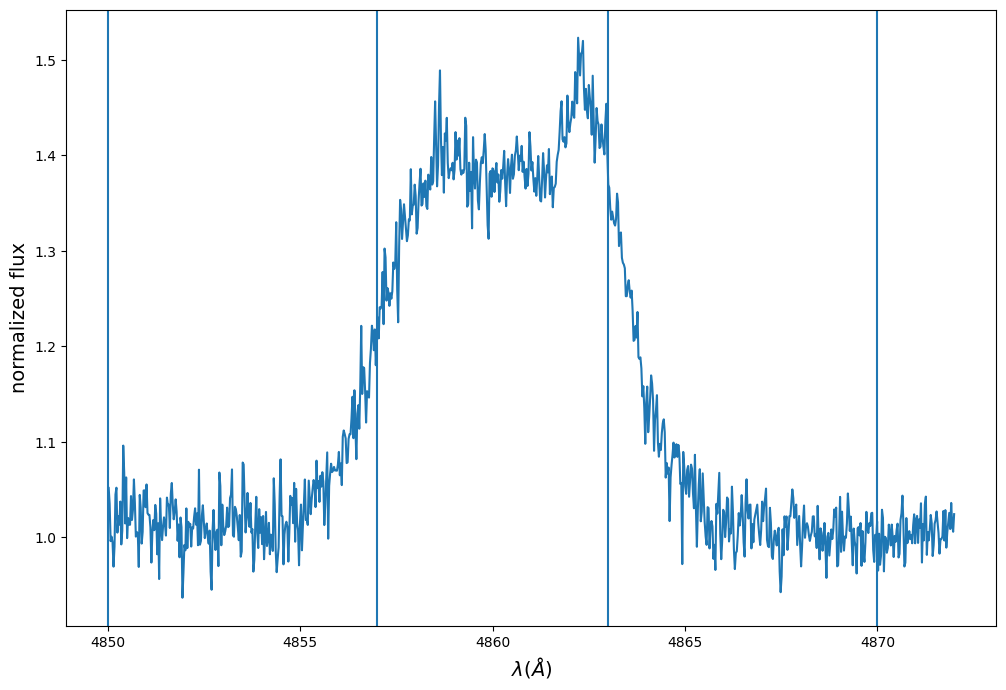

In [40]:
plt.figure(figsize = [12,8])
plt.plot(data['wave'], data['flux'])
plt.xlabel('$\lambda (\AA)$', size = 14)
plt.ylabel('normalized flux', size = 14)
plt.axvline(4850)
plt.axvline(4857)
plt.axvline(4863)
plt.axvline(4870)


In [43]:
rv_epoch, rv_err_epoch  = [], []
wave_plot, flux_plot, fitt_array_plot, result_plot = [], [], [], []

for k in range(0,len(infile)):
    arr = {'wave': read_HERMES(infile[k])[0],  'flux': read_HERMES(infile[k])[1]}
    df = Table(arr).to_pandas()
    data = df[(df['wave']>4850) & (df['wave']<4872)].reset_index()
    '''
    output = Cutdata().cut_data(data['wave'], data['flux'])
    min_blue_wave = output[0][output[3]]
    max_blue_wave = output[0][output[4]]
    min_red_wave = output[0][output[5]]
    max_red_wave = output[0][output[6]]
    '''
    left_data = data[(data['wave']>4850) & (data['wave']<4858)]
    right_data = data[(data['wave']>4863) & (data['wave']<4870)]
    wave = np.concatenate((np.array(left_data['wave']), np.array(right_data['wave'])))
    flux = np.concatenate((np.array(left_data['flux']), np.array(right_data['flux'])))
    wave_plot.append(data['wave'])
    flux_plot.append(data['flux'])

    model = VoigtModel() + ConstantModel()
    params = model.make_params(amplitude=1, center=4861, sigma=2, gamma=2, c=1)
    result = model.fit(flux, x=wave, params=params)
    #flux_fit = result.best_fit

    z = (4861.29 - result.best_values['center'])/4861.29
    z_err = (result.params['center'].stderr)/4861.29
    rv = 3*10**5*z
    rv_err = 3*10**5*z_err
    rv_epoch.append(rv)
    rv_err_epoch.append(rv_err)

    '''
    dt = ['gauss', k, rv, rv_err]
    from csv import writer
    with open('/content/drive/MyDrive/thesis_final_results/temp_h_beta/'+name+'.csv', 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(dt)
        f_object.close()
    '''
    fitt_array = np.arange(min(wave), max(wave), 0.01)
    result_new = result.eval(x=fitt_array)
    fitt_array_plot.append(fitt_array)
    result_plot.append(result_new)

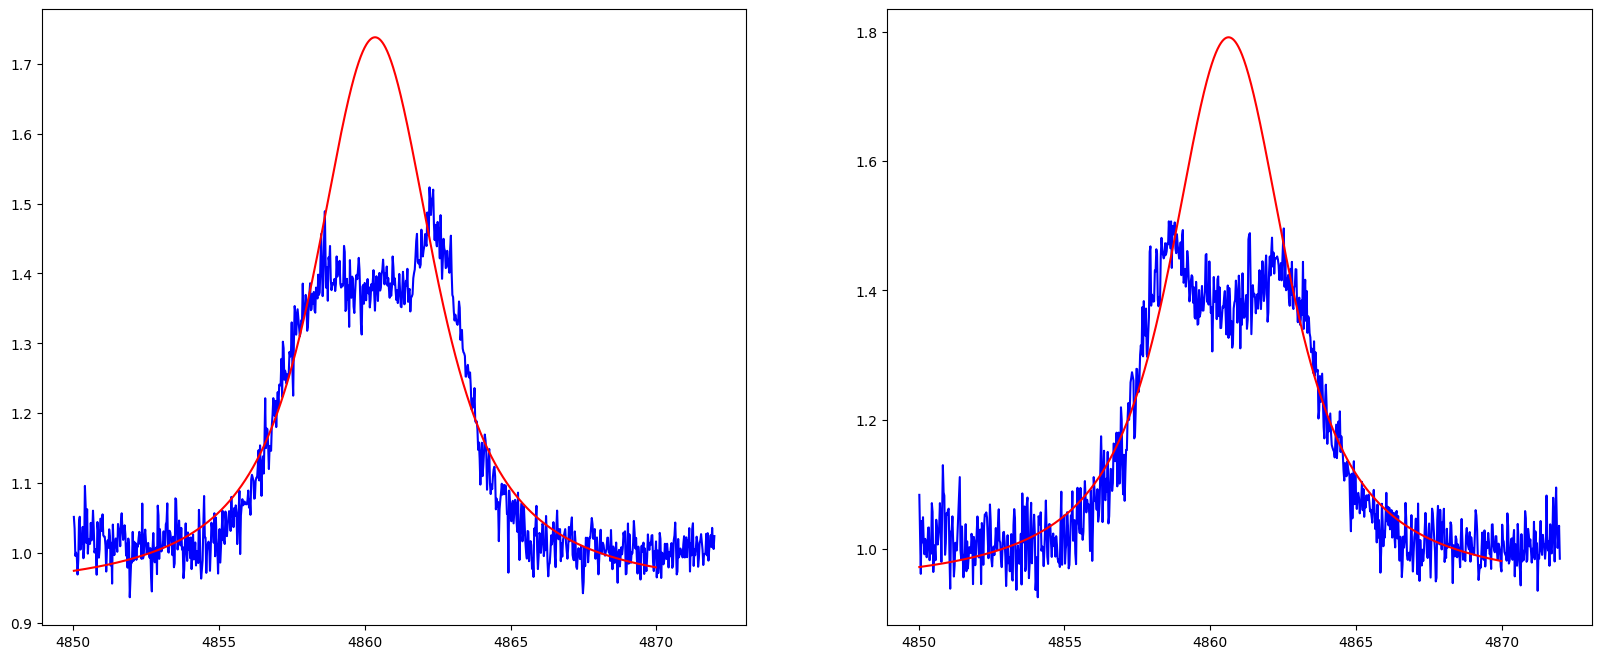

In [44]:
if len(infile) == 1:
  fig, ax = plt.subplots( figsize=(14, 8))
  fig.suptitle(name, size = 15)
  ax.plot(wave_plot[0], flux_plot[0], 'b')
  ax.plot(fitt_array_plot[0], result_plot[0], color = 'r')
  ax.annotate(str(round(rv_epoch[0],3)), (4852, 1.2), size = 15)
else:
  fig, ax = plt.subplots(nrows=1, ncols=len(infile), figsize=(20, 8))
  #fig.suptitle('BD+58_458', size = 17)
  for k in range(0, len(infile)):
    ax[k].plot(wave_plot[k], flux_plot[k], 'b')
    ax[k].plot(fitt_array_plot[k], result_plot[k], color = 'r')
    #ax[k].annotate(str(round(rv_epoch[k],3)), (4852, 1.2), size = 15)
#plt.savefig('/content/drive/MyDrive/thesis_final_results/temp_h_beta/'+name+'.png')

plt.savefig('h_beta.png', transparent = True)

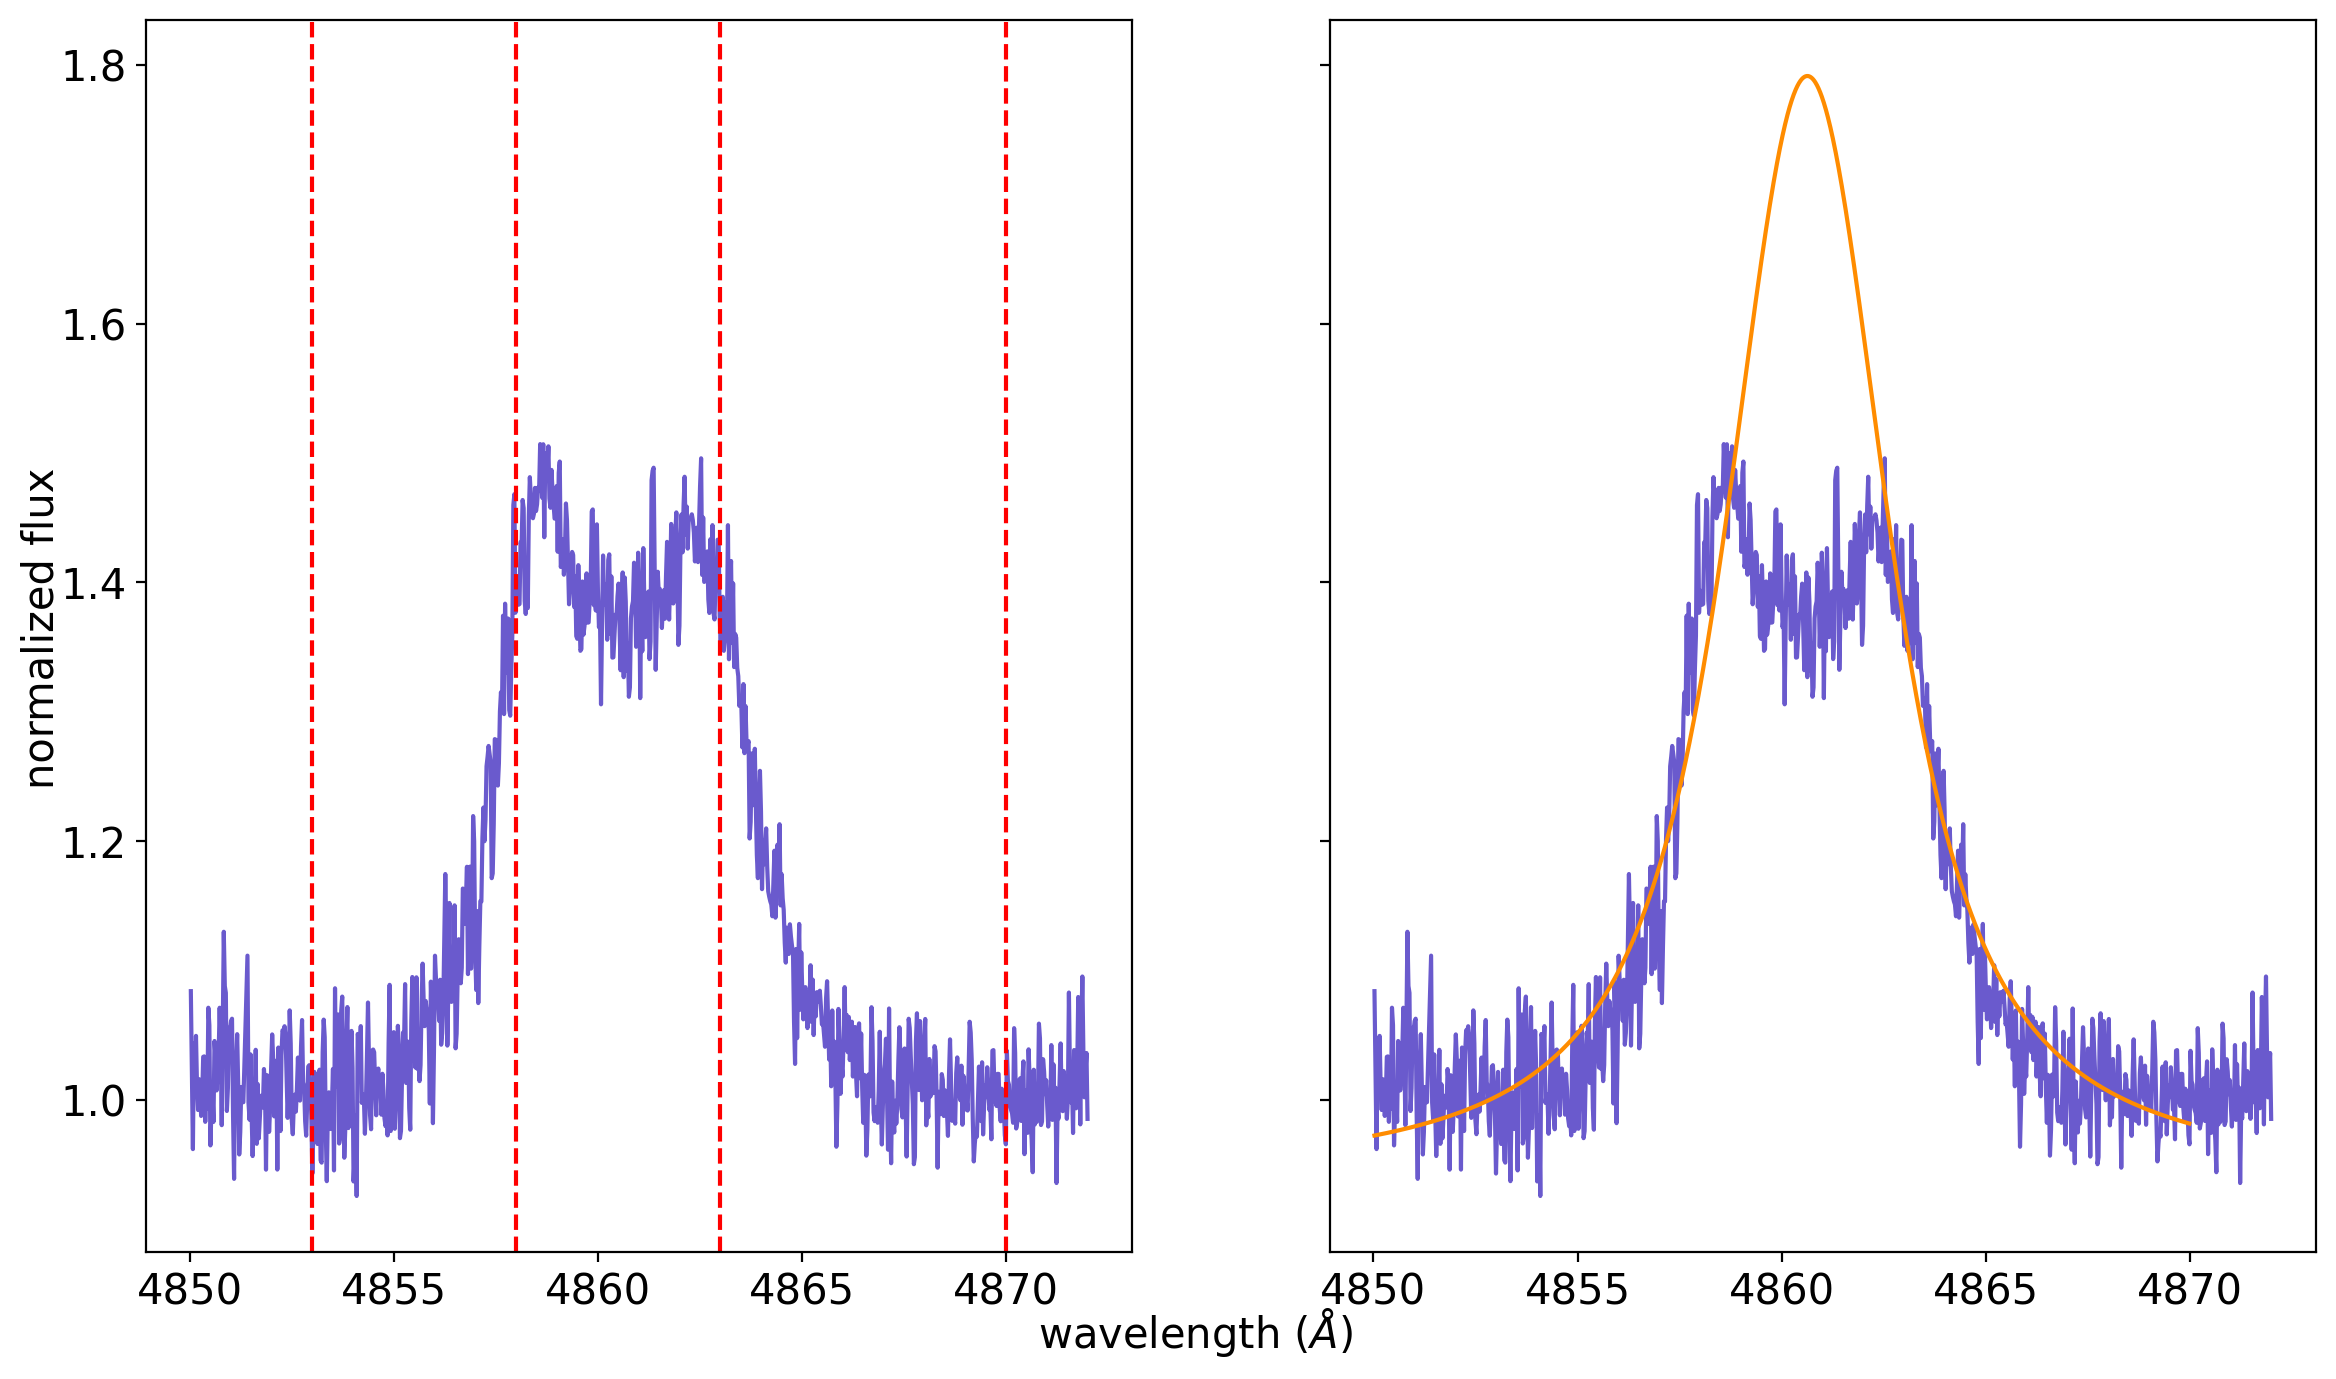

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi = 200, sharey= True, sharex = True)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[0].plot(wave_plot[k], flux_plot[k], 'slateblue')
ax[0].axvline(4853, linestyle = '--', color = 'r')
ax[0].axvline(4858, linestyle = '--', color = 'r')
ax[0].axvline(4863, linestyle = '--', color = 'r')
ax[0].axvline(4870, linestyle = '--', color = 'r')
ax[1].plot(wave_plot[k], flux_plot[k], 'slateblue')
ax[1].plot(fitt_array_plot[k], result_plot[k], color = 'darkorange')


fig.text(0.5, 0.05, 'wavelength ($\AA$)', ha='center', size = 15)
fig.text(0.08, 0.5, 'normalized flux', va='center', rotation='vertical', size = 15)
plt.savefig('halpha_fit.png')
